# Lifespan

Given the file `Macintosh_timeline.csv` which lists the Macintosh releases and decommisions do the following:

* Find the average lifespan of a Mac in days
* Plot a bar graph showing the total number of Mac devices associated with each family
* Which Mac device lasted the longest?  The Least?
* Create a bar graph showing the average lifespan of each family of Mac Products

# Setup
There's a few things to be done to setup the Notebook including imporing `pandas` and `matplotlib` and setting up the notebook to output plotting figures from `matplotlib` within the notebook.

In [2]:
%pylab inline

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Working with .csv files for data analysis

When working with csv files for data analysis there are multiple options out there.  The built-in `csv` module for Python is a great start for parsing all things comma (or other character) seperated files.  However, to make our lives even easier we're going to use `pandas` and import the .csv directly:

In [3]:
mac_timeline_data = pd.read_csv("Macintosh_timeline.csv")
mac_timeline_data.head()

,Year,Launched,Model,Family,Discontinued
0,1984,24-Jan,Macintosh 128K,Compact,9/10/1984
1,1984,10-Sep,Macintosh 512K,Compact,4/14/1986
2,1984,10-Sep,Macintosh 128K (revised),Compact,10/1/1985
3,1985,1-Jan,Macintosh XL,Compact,4/1/1985
4,1986,16-Jan,Macintosh Plus,Compact,1/1/1987


# Bar Graph Solution

Before plotting anything, we need to be able to isolate our data.  Within `pandas` we can select the `Family` column like so:

In [4]:
families = mac_timeline_data['Family']
families.head()

0    Compact
1    Compact
2    Compact
3    Compact
4    Compact
Name: Family, dtype: object

Futhermore, `pandas` has a built-in function for Data Series to determine the count of the values within that series:

In [5]:
families.value_counts()

MacBook               28
Power Macintosh       27
iMac                  19
PowerBook             16
Compact               14
Workgroup Server      10
Quadra                 9
Mac II                 8
Xserve                 8
LC                     8
PowerBook Duo          7
Mac mini               7
MacBook Pro            6
Mac Pro                6
Macintosh Server       5
iBook                  5
Performa               5
PowerBook G4           4
PowerBook G3           4
Network Server         3
PowerBook 500          3
Mac Mini               2
MacBook Air            2
Centris                2
Portable               2
Centris / Quadra       1
eMac                   1
Macbook                1
MacBook (Mid 2007)     1
Name: Family, dtype: int64

Now that we've isolated the data, let's plot using `matplotlib`'s bar graph:

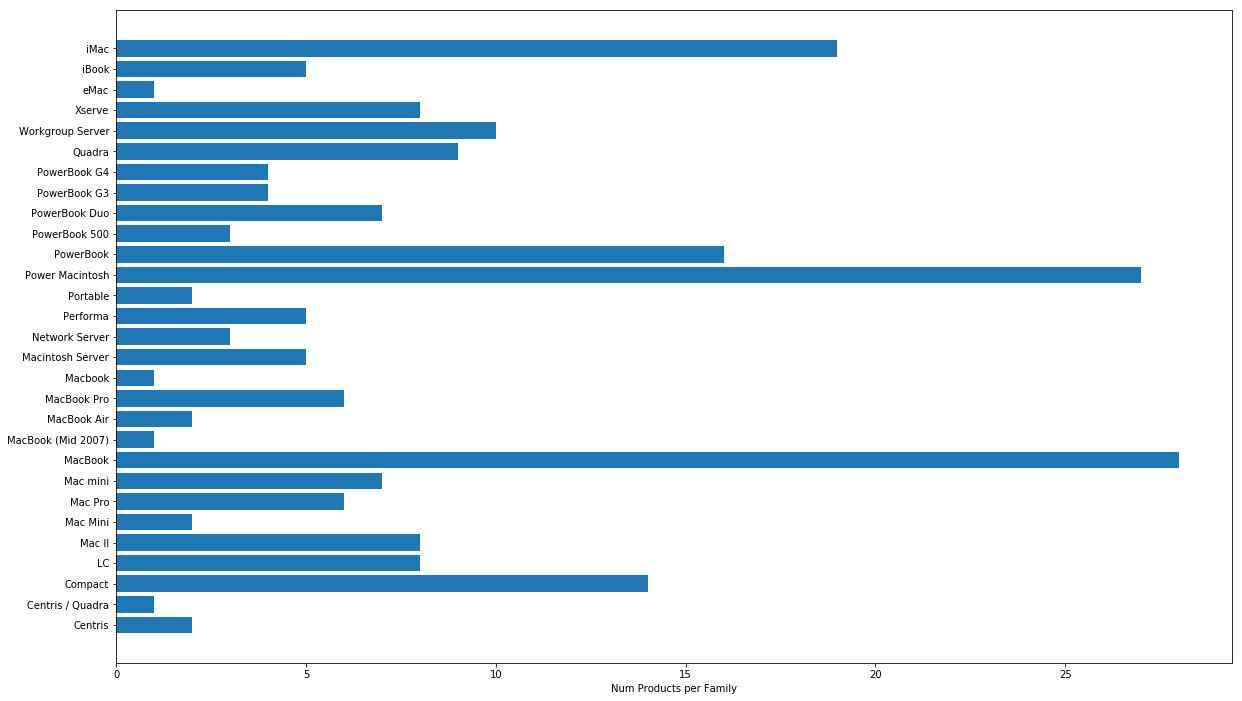

In [6]:
plt.rcParams['figure.figsize'] = (20, 12)
plt.barh(families.value_counts().index, families.value_counts().values)
plt.xlabel("Num Products per Family")
plt.show()

# Average lifespan of a Mac product

Determining the lifespan of a Mac product will require a small calculation:

$$
\frac{\sum_{i=0}^{n} discontinuedDate_i - launchedDate_i}{totalNumDevices} \forall discontinuedDate, launchedDate \in csvFile
$$

Looking at the data frame, there are a few challenges we're going to need to work out:
    * combining the columns "Year" and "Launched" into a single date for analysis
    * determining how to subtract the "Discontinued" and combined "Year" and "Launched" columns to determine a delta in dates
    * how do we handle non-date values (e.g. `current`)?
   

In [7]:
mac_timeline_data.tail()

,Year,Launched,Model,Family,Discontinued
209,2012,23-Oct,Mac mini (Late 2012),Mac mini,current
210,2013,13-Feb,MacBook Pro with Retina display (Early 2013),MacBook Pro,10/22/2013
211,2013,10-Jun,MacBook Air (Mid 2013),MacBook Air,current
212,2013,22-Oct,MacBook Pro with Retina display (Late 2013),MacBook Pro,current
213,2013,19-Dec,Mac Pro (Late 2013),Mac Pro,current


Let's first combine "Year" and "Launched" into a `datetime.date` object for working.  What if we had just two strings that represented the date?  How would we combine them?  Let's create a function `combine_date` to do just that:

In [8]:
import datetime as dt

def combine_date(day_month: str, year: str) -> dt.date:
    """
    This function take a string `day_month` in the format of "<day>-<month>" that 
    represents the day and month and another string `year` that represents the year
    combines them into a datetime.date object.
    """
    month_conv = {
        "Jan": 1,
        "Feb": 2,
        "Mar": 3,
        "Apr": 4,
        "May": 5,
        "Jun": 6,
        "Jul": 7,
        "Aug": 8,
        "Sep": 9,
        "Oct": 10,
        "Nov": 11,
        "Dec": 12
    }
    day, month = day_month.split("-")
    day = int(day)
    month = month_conv[month]
    return dt.date(year, month, day)

`pandas` DataFrames have a neat function called `apply` which "applies" a function to each row in the DateFrame.  That means that we need to select just the columns "Launched" and "Year".  This is pretty easily done like so:

In [9]:
mac_timeline_data[['Launched', 'Year']].head()

,Launched,Year
0,24-Jan,1984
1,10-Sep,1984
2,10-Sep,1984
3,1-Jan,1985
4,16-Jan,1986


So now let's "apply" our function to those columns and save it.  Note that `*x` extracts each row's values.  For example `*x` for the first row, this is the equivalent of `combine_date('24-Jan', '1984')`.

In [10]:
date_launched = mac_timeline_data[['Launched', 'Year']].apply(lambda x: combine_date(*x), axis=1)
date_launched.head()

0    1984-01-24
1    1984-09-10
2    1984-09-10
3    1985-01-01
4    1986-01-16
dtype: object

Now let's look at the "Discontinued" column of our data:

In [11]:
mac_timeline_data['Discontinued'].head()

0    9/10/1984
1    4/14/1986
2    10/1/1985
3     4/1/1985
4     1/1/1987
Name: Discontinued, dtype: object

This column of data is a little different.  I'm assuming it's a column of strings (hint: it is).  We'll need to convert this to a `datetime` object as well.  Let's create a function that take a single string in the format we expect `<month>/<day>/<year>` and convert it to a `datetime` object.  Remeber those "current" values, make sure we handle those by just returning them as `None` objects.  Finally, let's apply that function to each row of the "Disconintued" column and save it in another variable `date_discontinued`.  Examine the `head` and `tail` of the variable and see how it looks.

In [12]:
import time

def convert_to_datetime(d_str):
    if d_str == 'current':
        return None
    
    t_struct = time.strptime(d_str, "%m/%d/%Y")
    t_struct_str = time.mktime(t_struct)
    return dt.date.fromtimestamp(t_struct_str)
    
date_discontinued = mac_timeline_data['Discontinued'].apply(convert_to_datetime)
date_discontinued.head()

0    1984-09-10
1    1986-04-14
2    1985-10-01
3    1985-04-01
4    1987-01-01
Name: Discontinued, dtype: object

In [13]:
date_discontinued.tail()

209          None
210    2013-10-22
211          None
212          None
213          None
Name: Discontinued, dtype: object

Now that we've got our date's launched and discontinued in a nice format, let's create a new column in our `mac_timeline_delta` variable called "delta" to represent the number of days between "Launched" and "Discontinued".  Examine the `head` and `tail` of this new column.

In [14]:
mac_timeline_data['delta'] = date_discontinued - date_launched
mac_timeline_data['delta'].head()

0   230 days
1   581 days
2   386 days
3    90 days
4   350 days
Name: delta, dtype: timedelta64[ns]

In [15]:
mac_timeline_data['delta'].tail()

209        NaT
210   251 days
211        NaT
212        NaT
213        NaT
Name: delta, dtype: timedelta64[ns]

See the `NaT`?  That's a special Object within `pandas` to represent "Not a Time".  We'll need to filter out those dates since we can't calculate the average lifespan of the Mac products.  We can do this using a list comprehension.  Basically, iterate over the list and create a new one with ONLY the delta's that are actual numbers.

In [16]:
filtered_deltas = [t.days for t in mac_timeline_data['delta'] if t is not pd.NaT]

Now it's time to calculate the Average lifespan!  Take the sum of the list, then divide it by the len of the list:

In [17]:
avg_lifespan = sum(filtered_deltas) / len(filtered_deltas)
avg_lifespan

462.79227053140096

# Which Mac Product Lasted the Longest?  The Least?
How do we determine which value in a column is the max or min?  Pandas has builtin functions for that as well:

In [18]:
mac_timeline_data['delta'].max()

Timedelta('1528 days 00:00:00')

Whoa!  That's not necessarily what we wanted... sure we needed the value of the max delta, but what product was it?  Were there multiple?  How do we find that?  

This is where slicing/selecting whatever you want to call it in pandas is super powerfull.  Let's select all products that have a delta of 1528 days:

In [19]:
mac_timeline_data[mac_timeline_data.delta == mac_timeline_data['delta'].max()]

,Year,Launched,Model,Family,Discontinued,delta
127,2002,29-Apr,eMac,eMac,7/5/2006,1528 days


And here's how we find the min

In [20]:
mac_timeline_data[mac_timeline_data.delta == mac_timeline_data['delta'].min()]

,Year,Launched,Model,Family,Discontinued,delta
3,1985,1-Jan,Macintosh XL,Compact,4/1/1985,90 days


# Average Lifespan of the Mac Product Familes

In [21]:
family_names = list(set(mac_timeline_data['Family']))

family_lifespans = []
for family in family_names:
    lifespan_ds = mac_timeline_data[mac_timeline_data.Family == family]
    lifespan_vals = [val.days for val in lifespan_ds['delta'] if val is not pd.NaT]
    avg_lifespan = sum(lifespan_vals) / len(lifespan_vals)
    family_lifespans.append(avg_lifespan)

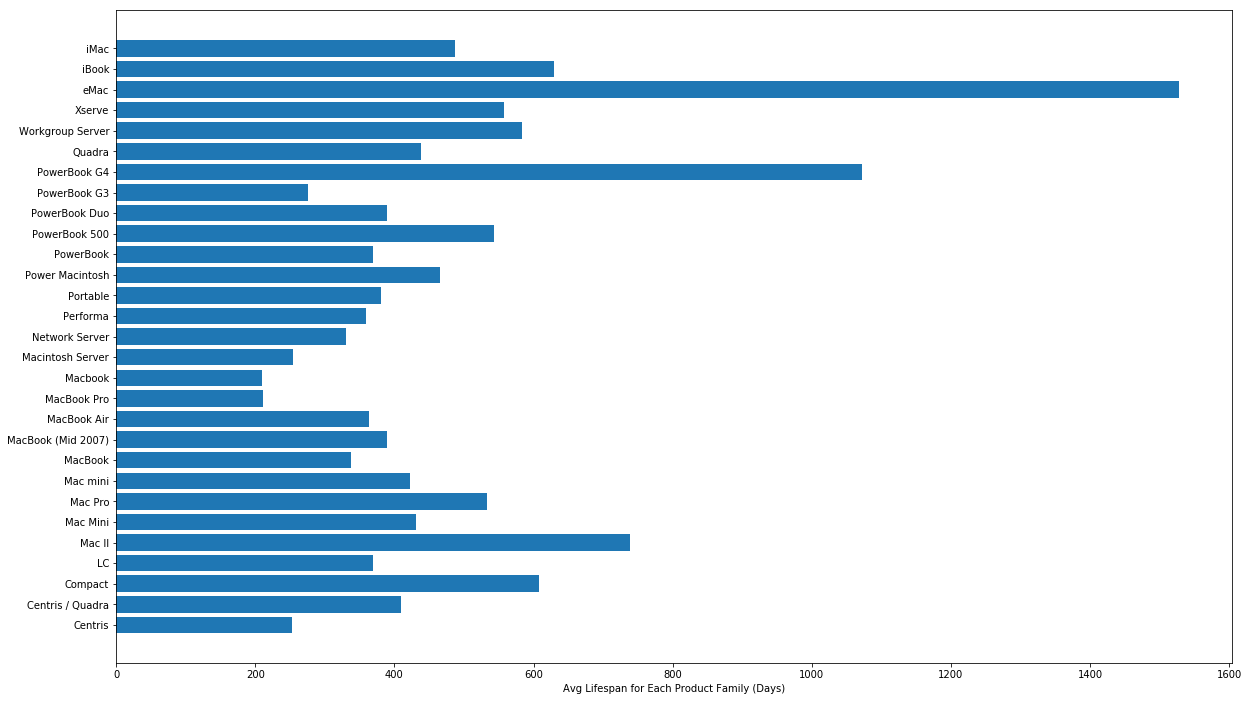

In [22]:
plt.rcParams['figure.figsize'] = (20, 12)
plt.barh(family_names, family_lifespans)
plt.xlabel("Avg Lifespan for Each Product Family (Days)")
plt.show()